# Fast GRF Graph Kernel with Train/Val/Test

Clean implementation of Fast Graph Random Features kernel with proper evaluation framework.

**New Features:**
- Optional downsampling for faster computation (configurable via USE_DOWNSAMPLING and DOWNSAMPLE_FACTOR)
- Self-contained: no external .npz file dependencies - computes data fresh from NetCDF
- Automatic cache management for different grid resolutions
- Proper Aeolus track snapping that works with both full and downsampled grids

### Preprocessing

In [50]:

%reload_ext autoreload
%autoreload 2
import torch
import gpytorch
from gpytorch import settings as gsettings

from linear_operator import settings
from linear_operator.utils import linear_cg
from linear_operator.operators import IdentityLinearOperator
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import mean_squared_error
import pandas as pd
from tqdm import tqdm
import sys
sys.path.append('../..')
from efficient_graph_gp_sparse.gptorch_kernels_sparse.sparse_grf_kernel import SparseGRFKernel
from efficient_graph_gp_sparse.preprocessor import GraphPreprocessor
from graph_bo.data.database import GraphDataLoader

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
output_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Output device: {output_device}")

def to_device(data, device):
    """Helper function to move data to device"""
    if isinstance(data, dict):
        return {k: to_device(v, device) for k, v in data.items()}
    elif isinstance(data, (list, tuple)):
        return [to_device(item, device) for item in data]
    elif isinstance(data, torch.Tensor):
        return data.to(device)
    else:
        return data

Output device: cuda:0


In [73]:

# =============================================================================
# EXPERIMENT CONFIGURATION
# =============================================================================

settings.verbose_linalg._default = False
settings._fast_covar_root_decomposition._default = False

# GPyTorch settings
gsettings.max_cholesky_size._global_value = 0
gsettings.cg_tolerance._global_value = 1e-2
gsettings.max_lanczos_quadrature_iterations._global_value = 20 # Small iterations so inaccurate loss estimation
settings.fast_computations.log_prob._state = True
gsettings.num_trace_samples._global_value = 64
gsettings.min_preconditioning_size._global_value = 1e10
# gpytorch.settings.max_eager_kernel_size = 0

# Data downsampling parameters
DOWNSAMPLE_FACTOR = 10      # Downsample by factor of 10 in both lat/lon directions
USE_DOWNSAMPLING = True     # Set to False to use full resolution

# Kernel parameters
WALKS_PER_NODE = 1000      # Number of random walks per node
P_HALT = 0.1               # Halt probability for random walks
MAX_WALK_LENGTH = 5        # Maximum walk length
RANDOM_WALK_SEED = 42      # Seed for random walk generation

# Step matrices cache settings
LOAD_FROM_DISK = False    # Whether to load precomputed step matrices
SAVE_TO_DISK = False        # Whether to save computed step matrices

# Training parameters
LEARNING_RATE = 0.01        # Adam optimizer learning rate
MAX_ITERATIONS = 1000       # Maximum training iterations
PATIENCE = 20              # Early stopping patience
PRINT_INTERVAL = 100        # Progress printing interval

# Inference parameters
PATHWISE_SAMPLES = 200      # Number of samples for pathwise inference

### Load the wind speed data

In [52]:
from netCDF4 import Dataset
nc_file = '../data/raw_data/wind_interpolation/8176c14c59fd8dc32a74a89b926cb7fd.nc'
dataset = Dataset(nc_file, mode="r")
print("Variables:", dataset.variables.keys())

Variables: dict_keys(['number', 'valid_time', 'pressure_level', 'latitude', 'longitude', 'expver', 'u', 'v'])


In [53]:
# Load coordinate arrays
lat = dataset.variables["latitude"][:]      # shape (721,)
lon = dataset.variables["longitude"][:]     # shape (1440,)

# Load wind components (eastward and northward)
# Dimensions: (valid_time=12, pressure_level=3, latitude=721, longitude=1440)
u = dataset.variables["u"][:]   # eastward wind
v = dataset.variables["v"][:]   # northward wind

In [54]:
# create a long-lat gird, with values being the u, v wind components
import numpy as np
lon_grid, lat_grid = np.meshgrid(lon, lat)
u_500 = u[0, 0, :, :]  # shape (721, 1440)
v_500 = v[0, 0, :, :]  # shape (721, 1440)

# =============================================================================
# OPTIONAL DOWNSAMPLING FOR FASTER COMPUTATION
# =============================================================================

def downsample_grid_data(lat, lon, u_data, v_data, factor=10):
    """
    Downsample the lat/lon grid and corresponding data by a given factor
    
    Parameters:
    -----------
    lat : array
        Latitude coordinates
    lon : array  
        Longitude coordinates
    u_data : array
        U wind component data (lat, lon)
    v_data : array
        V wind component data (lat, lon)
    factor : int
        Downsampling factor
        
    Returns:
    --------
    lat_down, lon_down, u_down, v_down : downsampled arrays
    """
    # Downsample coordinates
    lat_down = lat[::factor]
    lon_down = lon[::factor]
    
    # Downsample data using the same indices
    u_down = u_data[::factor, ::factor]
    v_down = v_data[::factor, ::factor]
    
    print(f"Original grid: {lat.shape} x {lon.shape} = {len(lat) * len(lon):,} points")
    print(f"Downsampled grid: {lat_down.shape} x {lon_down.shape} = {len(lat_down) * len(lon_down):,} points")
    print(f"Reduction factor: {(len(lat) * len(lon)) / (len(lat_down) * len(lon_down)):.1f}x smaller")
    
    return lat_down, lon_down, u_down, v_down

# Apply downsampling if enabled
if USE_DOWNSAMPLING:
    print("Applying downsampling...")
    lat_processed, lon_processed, u_500_processed, v_500_processed = downsample_grid_data(
        lat, lon, u_500, v_500, factor=DOWNSAMPLE_FACTOR
    )
else:
    print("Using full resolution...")
    lat_processed, lon_processed, u_500_processed, v_500_processed = lat, lon, u_500, v_500
    print(f"Full grid: {lat.shape} x {lon.shape} = {len(lat) * len(lon):,} points")

Applying downsampling...
Original grid: (721,) x (1440,) = 1,038,240 points
Downsampled grid: (73,) x (144,) = 10,512 points
Reduction factor: 98.8x smaller


In [55]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from skyfield.api import load, EarthSatellite, wgs84, utc

# ----------------------------
# Step 1: Define Aeolus TLE (example from repo)
# ----------------------------
line1 = "1 43600U 18066A   21153.73585495  .00031128  00000-0  12124-3 0  9990"
line2 = "2 43600  96.7150 160.8035 0006915  90.4181 269.7884 15.87015039160910"

ts = load.timescale()
aeolus = EarthSatellite(line1, line2, "AEOLUS", ts)

# ----------------------------
# Step 2: Generate times (every minute for 24h starting Jan 1, 2019 09:00 UTC)
# ----------------------------
start = datetime(2019, 1, 1, 9, tzinfo=utc)
stop = start + timedelta(hours=24)
step = timedelta(minutes=1)

times = []
t = start
while t <= stop:
    times.append(t)
    t += step

# ----------------------------
# Step 3: Propagate orbit to get lat/lon
# ----------------------------
geocentric = aeolus.at(ts.from_datetimes(times))
lat, lon = wgs84.latlon_of(geocentric)

# Convert to arrays in degrees
lat = lat.degrees
lon = lon.degrees % 360  # wrap to [0,360)

raw_track = pd.DataFrame({"time": times, "lat": lat, "lon": lon})

# ----------------------------
# Step 4: Snap to ERA5 grid (adjusted for downsampling)
# ----------------------------
if USE_DOWNSAMPLING:
    # Use the downsampled grid for snapping
    era5_lat = lat_processed  # Already downsampled
    era5_lon = lon_processed  # Already downsampled
    print(f"Snapping to downsampled grid: {len(era5_lat)} x {len(era5_lon)} points")
else:
    # Use original full resolution grid
    era5_lat = np.linspace(90, -90, 721)       # descending order
    era5_lon = np.linspace(0, 359.75, 1440)    # 0.25° spacing
    print(f"Snapping to full resolution grid: {len(era5_lat)} x {len(era5_lon)} points")

def snap_to_grid(lat_val, lon_val):
    i = np.abs(era5_lat - lat_val).argmin()
    j = np.abs(era5_lon - lon_val).argmin()
    return era5_lat[i], era5_lon[j]

snapped = [snap_to_grid(phi, lam) for phi, lam in zip(lat, lon)]
snap_lat, snap_lon = zip(*snapped)

snapped_track = pd.DataFrame({"time": times, "lat": snap_lat, "lon": snap_lon})

# ----------------------------
# Example outputs
# ----------------------------
print("Raw track sample:\n", raw_track.head())
print("Snapped track sample:\n", snapped_track.head())

Snapping to downsampled grid: 73 x 144 points
Raw track sample:
                        time        lat         lon
0 2019-01-01 09:00:00+00:00  38.799453  165.145970
1 2019-01-01 09:01:00+00:00  43.290230  163.965622
2 2019-01-01 09:02:00+00:00  47.767775  162.637952
3 2019-01-01 09:03:00+00:00  52.228839  161.108544
4 2019-01-01 09:04:00+00:00  56.668617  159.295027
Snapped track sample:
                        time   lat    lon
0 2019-01-01 09:00:00+00:00  40.0  165.0
1 2019-01-01 09:01:00+00:00  42.5  165.0
2 2019-01-01 09:02:00+00:00  47.5  162.5
3 2019-01-01 09:03:00+00:00  52.5  160.0
4 2019-01-01 09:04:00+00:00  57.5  160.0


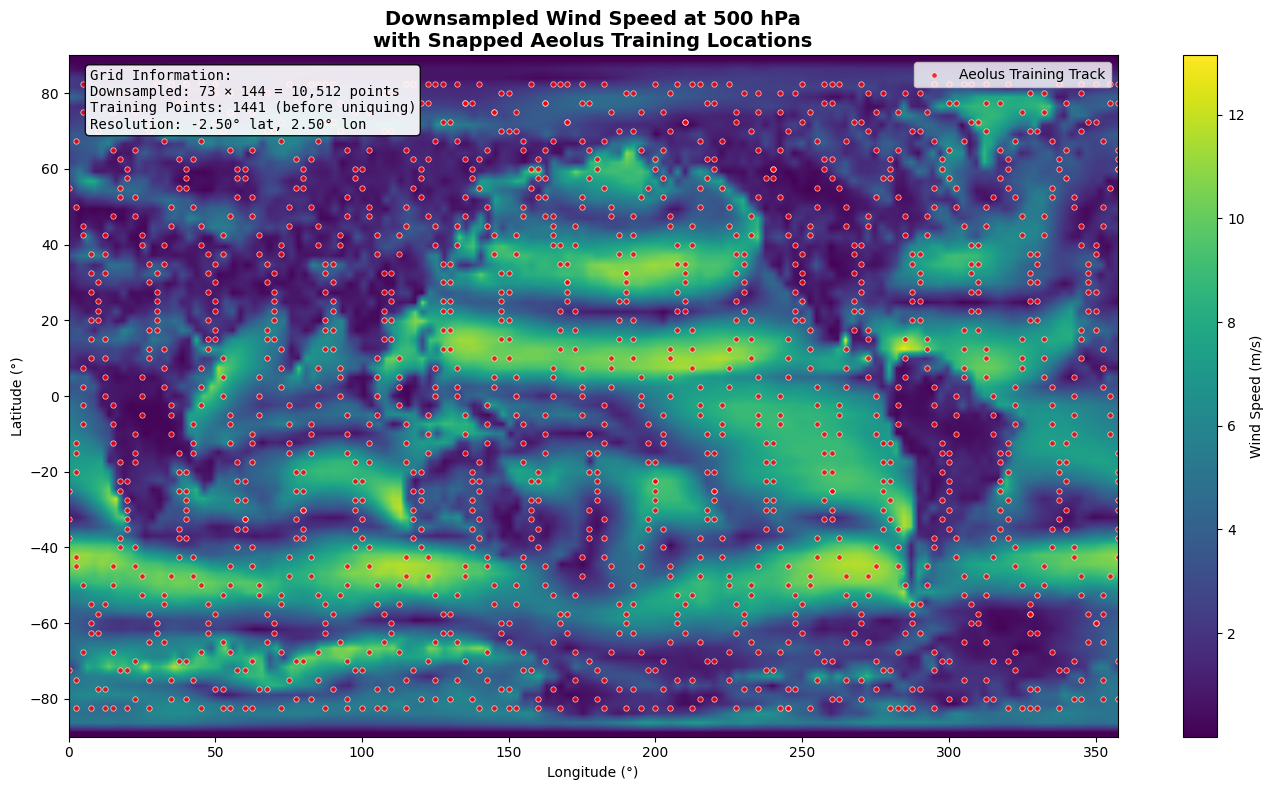


DOWNSAMPLED DATA VISUALIZATION
✅ Wind field: Downsampled
✅ Grid size: 73 × 144 = 10,512 points
✅ Training track: 1441 points snapped to grid
✅ Spatial resolution: -2.50° × 2.50°


In [56]:

# =============================================================================
# VISUALIZATION: DOWNSAMPLED DATA WITH TRAINING LOCATIONS
# =============================================================================

# Calculate wind speed magnitude for the processed (potentially downsampled) data
wind_speed_processed = np.sqrt(u_500_processed**2 + v_500_processed**2)

# Create visualization
plt.figure(figsize=(14, 8))

# Plot the wind speed field using processed data
im = plt.imshow(
    wind_speed_processed,
    extent=[lon_processed.min(), lon_processed.max(), 
           lat_processed.min(), lat_processed.max()],
    cmap="viridis",
    aspect="auto",
    origin="upper",  # because lat is descending
    interpolation='bilinear'
)
plt.colorbar(im, label="Wind Speed (m/s)")

# Overlay snapped Aeolus points
plt.scatter(
    snapped_track["lon"],
    snapped_track["lat"],
    c="red",
    s=15,
    marker="o",
    alpha=0.8,
    edgecolors='white',
    linewidth=0.5,
    label="Aeolus Training Track",
)

plt.title(f"{'Downsampled' if USE_DOWNSAMPLING else 'Full Resolution'} Wind Speed at 500 hPa\nwith Snapped Aeolus Training Locations", 
         fontsize=14, fontweight='bold')
plt.xlabel("Longitude (°)")
plt.ylabel("Latitude (°)")
plt.legend(loc='upper right')

# Add grid info as text
info_text = f"""Grid Information:
{'Downsampled' if USE_DOWNSAMPLING else 'Full Resolution'}: {len(lat_processed)} × {len(lon_processed)} = {len(lat_processed) * len(lon_processed):,} points
Training Points: {len(snapped_track)} (before uniquing)
Resolution: {(lat_processed[1] - lat_processed[0]):.2f}° lat, {(lon_processed[1] - lon_processed[0]):.2f}° lon"""

plt.text(0.02, 0.98, info_text, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.tight_layout()
plt.show()

print(f"\n{'='*50}")
print("DOWNSAMPLED DATA VISUALIZATION")
print(f"{'='*50}")
print(f"✅ Wind field: {'Downsampled' if USE_DOWNSAMPLING else 'Full resolution'}")
print(f"✅ Grid size: {len(lat_processed)} × {len(lon_processed)} = {len(lat_processed) * len(lon_processed):,} points")
print(f"✅ Training track: {len(snapped_track)} points snapped to grid")
print(f"✅ Spatial resolution: {(lat_processed[1] - lat_processed[0]):.2f}° × {(lon_processed[1] - lon_processed[0]):.2f}°")


In [57]:
import numpy as np
import networkx as nx
from scipy import sparse

# ----------------------------
# Utilities
# ----------------------------
def deg2rad(x):
    return np.deg2rad(x)

def sph2cart(lat_deg, lon_deg, r=1.0):
    """
    Convert geographic coords (degrees) to 3D unit-sphere (x,y,z).
    lat: [-90, +90], lon: [0, 360) or [-180,180)
    """
    lat = deg2rad(lat_deg)
    lon = deg2rad(lon_deg)
    x = r * np.cos(lat) * np.cos(lon)
    y = r * np.cos(lat) * np.sin(lon)
    z = r * np.sin(lat)
    return np.stack([x, y, z], axis=-1)

def great_circle_distance(lat1_deg, lon1_deg, lat2_deg, lon2_deg, R=1.0):
    """
    Great-circle distance using the haversine formula (on sphere radius R).
    Returns distance on the sphere surface (arc length).
    """
    lat1, lon1 = deg2rad(lat1_deg), deg2rad(lon1_deg)
    lat2, lon2 = deg2rad(lat2_deg), deg2rad(lon2_deg)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2.0 * np.arctan2(np.sqrt(a), np.sqrt(1.0 - a))
    return R * c

def grid_index(i, j, n_lat, n_lon):
    """Flatten (i,j) -> node id."""
    return i * n_lon + j

def inverse_grid_index(node_id, n_lat, n_lon):
    """Unflatten node id -> (i,j)."""
    i = node_id // n_lon
    j = node_id % n_lon
    return i, j

# ----------------------------
# Graph builder
# ----------------------------
def build_sphere_grid_graph(lat, lon, connectivity=4, weight="geodesic", radius=1.0):
    """
    Build a mesh-graph over a regular lat-lon grid on the sphere.

    Parameters
    ----------
    lat : (N_lat,) array (e.g., 721 from +90 to -90)
    lon : (N_lon,) array (e.g., 1440 from 0 to 359.75)
    connectivity : 4 or 8
        4-neighbour: north/south/east/west with periodic wrap in longitude
        8-neighbour: also connect diagonals
    weight : "geodesic" or None
        If "geodesic", weights are great-circle distances (arc length on sphere radius).
        If None, use unweighted edges.
    radius : float
        Sphere radius; 1.0 for unit sphere.

    Returns
    -------
    G : networkx.Graph
        Nodes [0..N_lat*N_lon-1] with attributes:
          - lat, lon (degrees)
          - xyz: (x,y,z) on unit sphere
    A : scipy.sparse.csr_matrix
        Weighted adjacency (symmetric).
    """
    n_lat = len(lat)
    n_lon = len(lon)

    # Precompute per-node attributes
    Lon_grid, Lat_grid = np.meshgrid(lon, lat)  # shapes (n_lat, n_lon)
    xyz = sph2cart(Lat_grid.ravel(), Lon_grid.ravel(), r=1.0)

    # Build edges
    rows = []
    cols = []
    data = []

    # neighbor offsets (diagonals optional)
    nbrs_4 = [(0, 1), (0, -1), (1, 0), (-1, 0)]          # E, W, S, N (i is lat index; note lat usually descending)
    nbrs_8 = nbrs_4 + [(1, 1), (1, -1), (-1, 1), (-1, -1)]
    nbrs = nbrs_8 if connectivity == 8 else nbrs_4

    for i in range(n_lat):
        for j in range(n_lon):
            nid = grid_index(i, j, n_lat, n_lon)
            for di, dj in nbrs:
                ii = i + di
                jj = (j + dj) % n_lon  # periodic in longitude
                if 0 <= ii < n_lat:
                    nid2 = grid_index(ii, jj, n_lat, n_lon)

                    if weight == "geodesic":
                        w = great_circle_distance(lat[i], lon[j], lat[ii], lon[jj], R=radius)
                    else:
                        w = 1.0

                    rows.append(nid)
                    cols.append(nid2)
                    data.append(w)

    # Symmetric adjacency
    A = sparse.coo_matrix((data, (rows, cols)), shape=(n_lat*n_lon, n_lat*n_lon))
    # Make explicitly symmetric (since we added both directions for E/W etc., this is safe)
    A = ((A + A.T) * 0.5).tocsr()

    # Build networkx graph from adjacency
    G = nx.from_scipy_sparse_array(A)
    # Attach node attributes
    node_attrs = {}
    for nid in range(n_lat * n_lon):
        i, j = inverse_grid_index(nid, n_lat, n_lon)
        node_attrs[nid] = {
            "lat": float(lat[i]),
            "lon": float(lon[j]),
            "xyz": tuple(xyz[nid]),
        }
    nx.set_node_attributes(G, node_attrs)

    return G, A

# ----------------------------
# Snapping helpers
# ----------------------------
def nearest_node_indices_for_track(track_lat, track_lon, lat, lon):
    """
    Given a track of points (lat, lon), return nearest grid (i,j) for each.
    Works for ERA5-style regular grid.

    Returns
    -------
    idx_ij : array of shape (N, 2) with int (i, j) indices.
    node_ids : array of shape (N,) flattened node ids.
    """
    # ERA5 latitude is often descending (90 -> -90); lon is uniform [0, 360)
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    track_lat = np.asarray(track_lat)
    track_lon = np.asarray(track_lon) % 360.0

    # nearest indices by absolute difference (fast for regular grid)
    i_idx = np.abs(track_lat[:, None] - lat[None, :]).argmin(axis=1)
    # Note: if your lon is [-180,180), normalize both to same frame first.
    j_idx = np.abs(track_lon[:, None] - lon[None, :]).argmin(axis=1)

    node_ids = i_idx * len(lon) + j_idx
    idx_ij = np.stack([i_idx, j_idx], axis=1)
    return idx_ij, node_ids


In [58]:
# Build graph using processed (potentially downsampled) coordinates
lat_for_graph = lat_processed
lon_for_graph = lon_processed
G, A = build_sphere_grid_graph(lat_for_graph, lon_for_graph, connectivity=4, weight="geodesic", radius=1.0)

# Snap Aeolus track to the processed (potentially downsampled) grid
idx_ij, node_ids = nearest_node_indices_for_track(
    track_lat=snapped_track["lat"].values,
    track_lon=snapped_track["lon"].values,
    lat=lat_for_graph, lon=lon_for_graph,
)

# Example: pull those nodes' 3D coordinates to plot on a sphere later
xyz_track = np.array([G.nodes[n]["xyz"] for n in node_ids])

print(f"Graph statistics:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Adjacency matrix shape: {A.shape}")
print(f"Number of Aeolus track points: {len(node_ids)}")
print(f"Unique track nodes: {len(np.unique(node_ids))}")

Graph statistics:
Number of nodes: 10512
Number of edges: 20880
Adjacency matrix shape: (10512, 10512)
Number of Aeolus track points: 1441
Unique track nodes: 1424


In [15]:
# =============================================================================
# FINAL DATA PREPARATION FOR MACHINE LEARNING
# =============================================================================

print("Preparing final datasets for training...")

# 1. Use the processed (potentially downsampled) wind data
lat_grid = lat_processed
lon_grid = lon_processed  
u_component = u_500_processed
v_component = v_500_processed

print(f"Using {'downsampled' if USE_DOWNSAMPLING else 'full resolution'} data:")
print(f"Grid shape: lat {lat_grid.shape}, lon {lon_grid.shape}")
print(f"Wind data shape: u {u_component.shape}, v {v_component.shape}")

# 2. Create adjacency matrix A (already computed above as sparse CSR)
A = A.tocsr()  # Ensure CSR format
print(f"Adjacency matrix A shape: {A.shape}, format: {A.format}")

# 3. Create node indices (consistent with graph construction)
n_lat, n_lon = len(lat_grid), len(lon_grid)
X = np.arange(n_lat * n_lon)  # Node indices [0, 1, 2, ..., n_nodes-1]

print(f"Node indices X shape: {X.shape}")

# 4. Create wind speed targets with CONSISTENT indexing
# Ensure the flattening matches our node indexing: node_id = i * n_lon + j
y = np.zeros(n_lat * n_lon)
coord_mapping = np.zeros((n_lat * n_lon, 2))

for i in range(n_lat):
    for j in range(n_lon):
        node_id = i * n_lon + j  # Same indexing as in graph construction
        
        # Extract wind components at this grid point
        u_val = u_component[i, j]
        v_val = v_component[i, j]
        wind_speed = np.sqrt(u_val**2 + v_val**2)
        
        # Assign to correct node index
        y[node_id] = wind_speed
        
        # Store coordinate mapping for reference
        coord_mapping[node_id, 0] = lat_grid[i]  # latitude
        coord_mapping[node_id, 1] = lon_grid[j]  # longitude

print(f"Wind speed targets y shape: {y.shape}")

# 4.1. Normalize wind speeds (zero mean, unit variance)
y_raw = y.copy()  # Keep original for reference
y_mean = np.mean(y)
y_std = np.std(y)

# Apply normalization
y = (y - y_mean) / y_std

print(f"Wind speed normalization:")
print(f"  Original: mean={y_mean:.3f} m/s, std={y_std:.3f} m/s")
print(f"  Normalized: mean={np.mean(y):.6f}, std={np.std(y):.6f}")
print(f"  Range: [{np.min(y):.3f}, {np.max(y):.3f}]")

# 5. Create training locations (Aeolus satellite track node indices)
# Get unique node indices from the Aeolus track
unique_train_nodes = np.unique(node_ids)
X_train = unique_train_nodes  # Training node indices
y_train = y[X_train]  # Corresponding wind speeds at those nodes

print(f"Training node indices X_train shape: {X_train.shape}")
print(f"Training wind speeds y_train shape: {y_train.shape}")

# 6. Verify consistency
print(f"\nVerification:")
print(f"X min: {X.min()}, max: {X.max()}")
print(f"y length: {len(y)}")
print(f"X_train min: {X_train.min()}, max: {X_train.max()}")
print(f"All X_train indices within y bounds: {np.all(X_train < len(y))}")

# 7. Summary of final datasets
print("\n" + "="*60)
print("FINAL DATASET SUMMARY")
print("="*60)
print(f"A (adjacency matrix):     {A.shape} sparse CSR")
print(f"X (node indices):         {X.shape} - node indices [0, 1, ..., {len(X)-1}]")
print(f"y (wind speeds):          {y.shape} - wind speed magnitudes")
print(f"X_train (training nodes): {X_train.shape} - Aeolus track node indices")
print(f"y_train (training speeds): {y_train.shape} - Wind speeds at Aeolus locations")
print(f"coord_mapping:            {coord_mapping.shape} - (lat, lon) for each node")

# 8. Save the prepared datasets
# Also save original u,v components with consistent indexing
u_flat_consistent = np.zeros(n_lat * n_lon)
v_flat_consistent = np.zeros(n_lat * n_lon)

for i in range(n_lat):
    for j in range(n_lon):
        node_id = i * n_lon + j
        u_flat_consistent[node_id] = u_component[i, j]
        v_flat_consistent[node_id] = v_component[i, j]

np.savez('wind_data_processed_500hPa.npz',
         A_data=A.data,
         A_indices=A.indices, 
         A_indptr=A.indptr,
         A_shape=A.shape,
         X=X,
         y=y,  # Normalized wind speeds
         y_mean=y_mean,  # Normalization mean (for reference)
         y_std=y_std,   # Normalization std (for reference)
         X_train=X_train,
         y_train=y_train,
         coord_mapping=coord_mapping,
         u_component=u_flat_consistent,  # Consistently indexed u components
         v_component=v_flat_consistent)  # Consistently indexed v components

print(f"\nAll datasets saved to 'wind_data_processed_500hPa.npz'")
print("Use scipy.sparse.csr_matrix((data, indices, indptr), shape) to reconstruct A")
print("Use coord_mapping[node_idx] to get (lat, lon) coordinates for any node")
print("X and y are now consistently indexed: y[X[i]] gives wind speed for node i")

Preparing final datasets for training...
Using downsampled data:
Grid shape: lat (73,), lon (144,)
Wind data shape: u (73, 144), v (73, 144)
Adjacency matrix A shape: (10512, 10512), format: csr
Node indices X shape: (10512,)
Wind speed targets y shape: (10512,)
Wind speed normalization:
  Original: mean=4.096 m/s, std=2.860 m/s
  Normalized: mean=-0.000000, std=1.000000
  Range: [-1.432, 3.164]
Training node indices X_train shape: (1424,)
Training wind speeds y_train shape: (1424,)

Verification:
X min: 0, max: 10511
y length: 10512
X_train min: 434, max: 10071
All X_train indices within y bounds: True

FINAL DATASET SUMMARY
A (adjacency matrix):     (10512, 10512) sparse CSR
X (node indices):         (10512,) - node indices [0, 1, ..., 10511]
y (wind speeds):          (10512,) - wind speed magnitudes
X_train (training nodes): (1424,) - Aeolus track node indices
y_train (training speeds): (1424,) - Wind speeds at Aeolus locations
coord_mapping:            (10512, 2) - (lat, lon) for e

In [16]:
data = {
    'A': A,
    'X': torch.tensor(X, dtype=torch.float32, device=output_device).unsqueeze(1),
    'y': torch.tensor(y, dtype=torch.float32, device=output_device),  # Normalized
    'X_train': torch.tensor(X_train, dtype=torch.float32, device=output_device).unsqueeze(1),
    'y_train': torch.tensor(y_train, dtype=torch.float32, device=output_device),  # Normalized
    'coord_mapping': coord_mapping,
    'u_component': torch.tensor(u_flat_consistent, dtype=torch.float32, device=output_device),
    'v_component': torch.tensor(v_flat_consistent, dtype=torch.float32, device=output_device)   
}

print(f"Data prepared with normalization:")
print(f"  All data in normalized scale: mean=0, std=1")
print(f"  Original stats: mean={y_mean:.3f} m/s, std={y_std:.3f} m/s")

Data prepared with normalization:
  All data in normalized scale: mean=0, std=1
  Original stats: mean=4.096 m/s, std=2.860 m/s


In [18]:
# Precompute the step matrices for the kernel
# Create cache filename that reflects downsampling settings
cache_suffix = f"_ds{DOWNSAMPLE_FACTOR}" if USE_DOWNSAMPLING else "_fullres"
# cache_filename = f'../data/step_matrices/500hpa/step_matrices_walks_{WALKS_PER_NODE}_halt_{P_HALT}_maxlen_{MAX_WALK_LENGTH}_seed_{RANDOM_WALK_SEED}{cache_suffix}.pkl'

pp = GraphPreprocessor(
    adjacency_matrix=data['A'],
    walks_per_node=WALKS_PER_NODE,
    p_halt=P_HALT,
    max_walk_length=MAX_WALK_LENGTH,
    random_walk_seed=RANDOM_WALK_SEED,
    load_from_disk=LOAD_FROM_DISK,
    use_tqdm=True,
    # cache_filename=cache_filename,
    n_processes=None)

if not LOAD_FROM_DISK:
    step_matrices_torch = pp.preprocess_graph(save_to_disk=SAVE_TO_DISK)
else:
    step_matrices_torch = pp.step_matrices_torch

# Move step matrices to device
step_matrices_torch = [step_matrix.to(output_device) for step_matrix in step_matrices_torch]

Process walks: 100%|██████████| 526/526 [00:29<00:00, 18.12it/s]
/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/graph_bo/notebooks/../../efficient_graph_gp_sparse/preprocessor/graph_preprocessor.py:135: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return torch.sparse_csr_tensor(


### Model Definition

In [19]:
# Model definition
class GraphGPModel(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood, step_matrices_torch):
        super().__init__(x_train, y_train, likelihood)
        self.x_train = x_train
        self.y_train = y_train
        self.mean_module = gpytorch.means.ZeroMean()
        self.step_matrices_torch = step_matrices_torch
        self.covar_module = SparseGRFKernel( 
            max_walk_length=MAX_WALK_LENGTH, 
            step_matrices_torch=self.step_matrices_torch
        )
        self.num_nodes = step_matrices_torch[0].shape[0]
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    def predict(self, x_test, n_samples=64):
        """
        Batch pathwise conditioning sampling.
        
        f_test_posterior = f_test_prior + K_test_train @ v
        v = (K_train_train + noise_variance*I)^{-1} @ (y_train - (f_train_prior + eps))
        f_test_prior and f_train_prior are jointly sampled from N(0, K)
        eps ~ N(0, noise_variance*I)
        
        Args:
            x_test (torch.Tensor): Test input locations (shape: [n_test, 1])
            n_samples (int): Number of samples to generate from the posterior
        """    
        
        num_train = self.x_train.shape[0]
        train_indices = self.x_train.int().flatten()
        test_indices = x_test.int().flatten()
        
        # Get feature matrix and extract submatrices
        phi = self.covar_module._get_feature_matrix()
        phi_train = phi[train_indices, :]
        phi_test = phi[test_indices, :]
        
        # Precompute covariance matrices
        K_train_train = phi_train @ phi_train.T
        K_test_train = phi_test @ phi_train.T
        
        # Noise parameters
        noise_variance = self.likelihood.noise.item()
        noise_std = np.sqrt(noise_variance)
        A = K_train_train + noise_variance * IdentityLinearOperator(num_train, device=x_test.device)
        
        # Generate batch random samples
        eps1_batch = torch.randn(n_samples, self.num_nodes, device=x_test.device)
        eps2_batch = noise_std * torch.randn(n_samples, num_train, device=x_test.device)
        
        # Batch compute prior samples
        f_test_prior_batch = eps1_batch @ phi_test.T
        f_train_prior_batch = eps1_batch @ phi_train.T
        
        # Batch compute RHS vectors
        b_batch = self.y_train.unsqueeze(0) - (f_train_prior_batch + eps2_batch)
        
        # Batched CG solve:
        v_batch = linear_cg(
            matmul_closure=A._matmul,
            rhs=b_batch.T,
            tolerance=settings.cg_tolerance.value()
        )
        
        # Posterior samples at test inputs
        f_test_posterior_batch = f_test_prior_batch + (K_test_train @ v_batch).T

        return f_test_posterior_batch

# Initialize model and move to device
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood = likelihood.to(output_device)
model = GraphGPModel(data['X_train'], data['y_train'], likelihood, step_matrices_torch)
model = model.to(output_device)

In [20]:
# GPU setup confirmation
print(f"Model device: {next(model.parameters()).device}")
print(f"Data devices: X_train={data['X_train'].device}, y_train={data['y_train'].device}")
print(f"Step matrices device: {step_matrices_torch[0].device}")

Model device: cuda:0
Data devices: X_train=cuda:0, y_train=cuda:0
Step matrices device: cuda:0


### Training Loop

In [21]:
# Training function
def train_model(model, likelihood, data, lr=0.01, max_iter=100):
    """Train model"""
    model.train()
    likelihood.train()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    train_losses = []
    
    for i in range(max_iter):
        # Training step
        optimizer.zero_grad()
        train_output = model(data['X_train'])
        train_loss = -mll(train_output, data['y_train'])
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())
        
        if i % PRINT_INTERVAL == 0:
            modulator = model.covar_module.modulator_vector.detach().cpu().numpy()
            print(f'Iter {i+1}: (Est) Train Loss={train_loss:.3f}, modulator={modulator}, noise={likelihood.noise.item():.4f}')
        
    return train_losses

# Train model using configured parameters
train_losses = train_model(
    model, likelihood, data, 
    lr=LEARNING_RATE, 
    max_iter=MAX_ITERATIONS
)

/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/venv/lib/python3.12/site-packages/linear_operator/utils/sparse.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():
/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/venv/lib/python3.12/site-packages/linear_operator/utils/sparse.py:66: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  res = cls(index_tensor, value_tensor, interp_size)
/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/venv/lib/python3.12/site-packages/linear_ope

Iter 1: (Est) Train Loss=2.307, modulator=[ 0.34669036  0.13880941  0.24446237  0.24033304 -1.1128564 ], noise=0.6883
Iter 101: (Est) Train Loss=1.432, modulator=[-0.04849065  0.05494314  0.4014918   0.5724336  -0.4782977 ], noise=0.3744
Iter 101: (Est) Train Loss=1.432, modulator=[-0.04849065  0.05494314  0.4014918   0.5724336  -0.4782977 ], noise=0.3744
Iter 201: (Est) Train Loss=1.401, modulator=[-0.21697642 -0.02992174  0.3024586   0.4766254  -0.33977088], noise=0.6646
Iter 201: (Est) Train Loss=1.401, modulator=[-0.21697642 -0.02992174  0.3024586   0.4766254  -0.33977088], noise=0.6646
Iter 301: (Est) Train Loss=1.390, modulator=[-0.34420842 -0.00572254  0.23021118  0.35631558 -0.22623497], noise=0.7902
Iter 301: (Est) Train Loss=1.390, modulator=[-0.34420842 -0.00572254  0.23021118  0.35631558 -0.22623497], noise=0.7902
Iter 401: (Est) Train Loss=1.379, modulator=[-0.6296913   0.14644589  0.20630427  0.22619079 -0.13450523], noise=0.7747
Iter 401: (Est) Train Loss=1.379, modulato

### Inference

In [22]:
# Predict on all nodes for visualization
print("\n=== GENERATING FULL GRAPH PREDICTIONS ===")
with torch.no_grad():
    X_all = torch.arange(len(data['y']), dtype=torch.float32, device=output_device).unsqueeze(1)
    all_samples = model.predict(X_all, n_samples=PATHWISE_SAMPLES)
    
    all_mean = all_samples.mean(dim=0)
    all_std = all_samples.std(dim=0)

print(f"Generated predictions for all {len(data['y'])} nodes")
print(f"All predictions in normalized scale (mean=0, std=1)")
print(f"Prediction range: [{all_mean.min():.3f}, {all_mean.max():.3f}]")


=== GENERATING FULL GRAPH PREDICTIONS ===
Generated predictions for all 10512 nodes
All predictions in normalized scale (mean=0, std=1)
Prediction range: [-2.012, 3.029]


### Simple Approach: Normalized Data Throughout

**Consistent Scale:**
- Wind speeds are **normalized** (mean=0, std=1) 
- GP model trains on normalized data
- All predictions and visualizations use normalized scale
- **Interpretation**: 0 = average wind, +1 = one std above average, -1 = one std below average

This keeps everything simple and consistent - no need for denormalization!

### Visualization

Creating wind prediction visualization...


/tmp/ipykernel_48270/879692878.py:78: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=10)


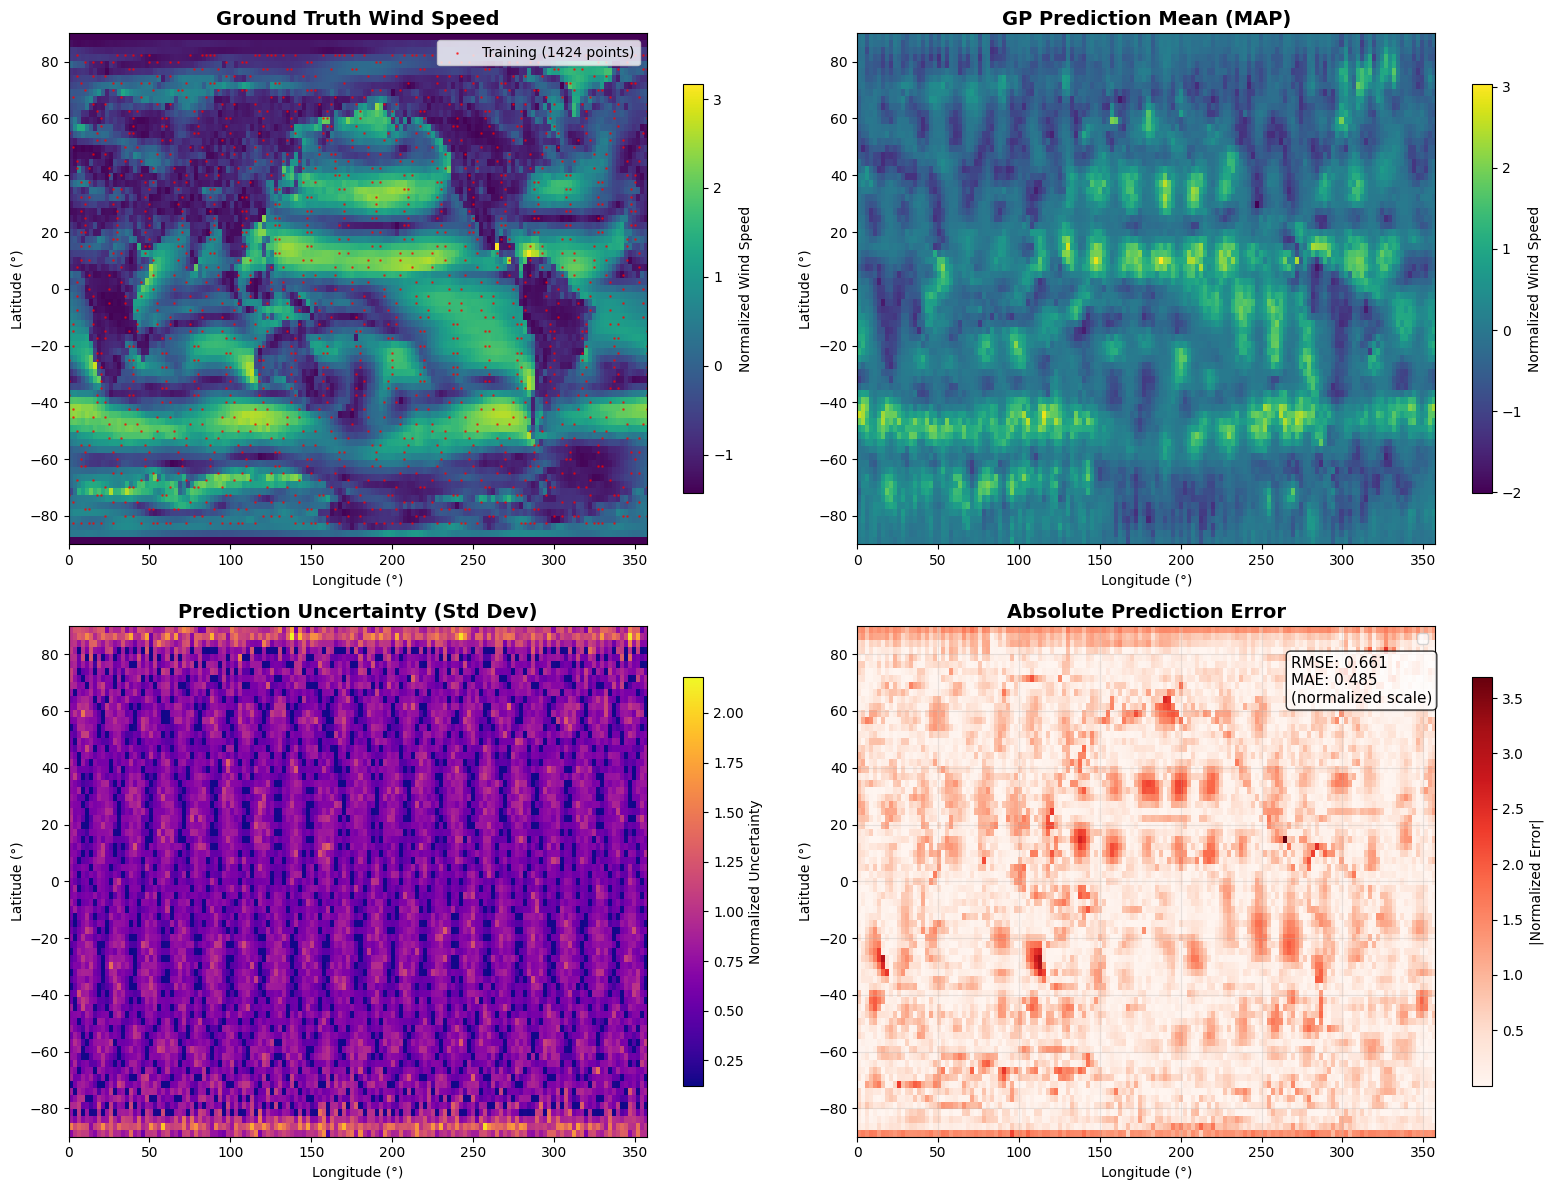


PREDICTION SUMMARY (Normalized Scale):
RMSE: 0.6608
MAE:  0.4849
Bias: 0.0311
Mean Uncertainty: 0.6562
Note: 0=avg wind, ±1=±1 std dev
Training Points: 1,424
Training Coverage: 13.55%


In [23]:
# =============================================================================
# SIMPLE 4-PANEL VISUALIZATION FUNCTION
# =============================================================================

def plot_wind_prediction_results(show_training_locations=True, figsize=(16, 12)):
    """
    Create a clean 4-panel visualization of wind prediction results
    
    Parameters:
    -----------
    show_training_locations : bool
        Whether to overlay training locations on ground truth plot
    figsize : tuple
        Figure size (width, height)
    """
    
    # Prepare data - use ACTUAL data dimensions
    n_lat, n_lon = len(lat_grid), len(lon_grid)  # Use processed grid dimensions
    y_true_2d = data['y'].cpu().numpy().reshape((n_lat, n_lon))  # Normalized scale
    y_pred_2d = all_mean.cpu().numpy().reshape((n_lat, n_lon))
    uncertainty_2d = all_std.cpu().numpy().reshape((n_lat, n_lon))
    error_2d = y_pred_2d - y_true_2d
    
    # Get coordinates
    unique_lats = np.unique(data['coord_mapping'][:, 0])
    unique_lons = np.unique(data['coord_mapping'][:, 1])
    unique_lats = np.sort(unique_lats)[::-1]  # Descending: 90 to -90
    unique_lons = np.sort(unique_lons)        # Ascending: 0 to 359.75
    
    extent = [unique_lons.min(), unique_lons.max(), unique_lats.min(), unique_lats.max()]
    
    # Create figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # 1. Ground Truth Wind Magnitude
    ax = axes[0, 0]
    im1 = ax.imshow(y_true_2d, extent=extent, cmap='viridis', aspect='auto', origin='upper')
    
    # Optionally overlay training locations
    if show_training_locations:
        train_indices = data['X_train'].flatten().int().cpu().numpy()
        train_coords = data['coord_mapping'][train_indices]
        train_lats = train_coords[:, 0]
        train_lons = train_coords[:, 1]
        ax.scatter(train_lons, train_lats, c='red', s=0.8, alpha=0.6, 
                  label=f'Training ({len(train_lats)} points)')
        ax.legend(loc='upper right', fontsize=10)
    
    ax.set_title('Ground Truth Wind Speed', fontsize=14, fontweight='bold')
    ax.set_xlabel('Longitude (°)')
    ax.set_ylabel('Latitude (°)')
    plt.colorbar(im1, ax=ax, label='Normalized Wind Speed', shrink=0.8)
    
    # 2. Prediction Mean (MAP)
    ax = axes[0, 1]
    im2 = ax.imshow(y_pred_2d, extent=extent, cmap='viridis', aspect='auto', origin='upper')
    ax.set_title('GP Prediction Mean (MAP)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Longitude (°)')
    ax.set_ylabel('Latitude (°)')
    plt.colorbar(im2, ax=ax, label='Normalized Wind Speed', shrink=0.8)
    
    # 3. Prediction Uncertainty
    ax = axes[1, 0]
    im3 = ax.imshow(uncertainty_2d, extent=extent, cmap='plasma', aspect='auto', origin='upper')
    ax.set_title('Prediction Uncertainty (Std Dev)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Longitude (°)')
    ax.set_ylabel('Latitude (°)')
    plt.colorbar(im3, ax=ax, label='Normalized Uncertainty', shrink=0.8)
    
    # 4. Absolute Error Field (2D Heatmap)
    ax = axes[1, 1]
    abs_error_2d = np.abs(error_2d)
    im4 = ax.imshow(abs_error_2d, extent=extent, cmap='Reds', aspect='auto', origin='upper')
    ax.set_title('Absolute Prediction Error', fontsize=14, fontweight='bold')
    ax.set_xlabel('Longitude (°)')
    ax.set_ylabel('Latitude (°)')
    plt.colorbar(im4, ax=ax, label='|Normalized Error|', shrink=0.8)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add error statistics as text
    rmse = np.sqrt(np.mean(error_2d**2))
    mae = np.mean(np.abs(error_2d))
    stats_text = f'RMSE: {rmse:.3f}\nMAE: {mae:.3f}\n(normalized scale)'
    ax.text(0.75, 0.85, stats_text, transform=ax.transAxes, fontsize=11,
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nPREDICTION SUMMARY (Normalized Scale):")
    print(f"{'='*40}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"Bias: {np.mean(error_2d):.4f}")
    print(f"Mean Uncertainty: {np.mean(uncertainty_2d):.4f}")
    print(f"Note: 0=avg wind, ±1=±1 std dev")
    if show_training_locations:
        print(f"Training Points: {len(train_lats):,}")
        print(f"Training Coverage: {len(train_lats)/y_true_2d.size*100:.2f}%")

# Call the function to create the plots
print("Creating wind prediction visualization...")
plot_wind_prediction_results(show_training_locations=True, figsize=(16, 12))

Creating regional zoom visualizations...

1. Atlantic Ocean Region:
Regional Analysis:
Region: lat [30.0, 50.0]°, lon [320.0, 340.0]°
Regional grid: (9, 9)
Training points in region: 10
Regional RMSE: 0.371 (normalized)


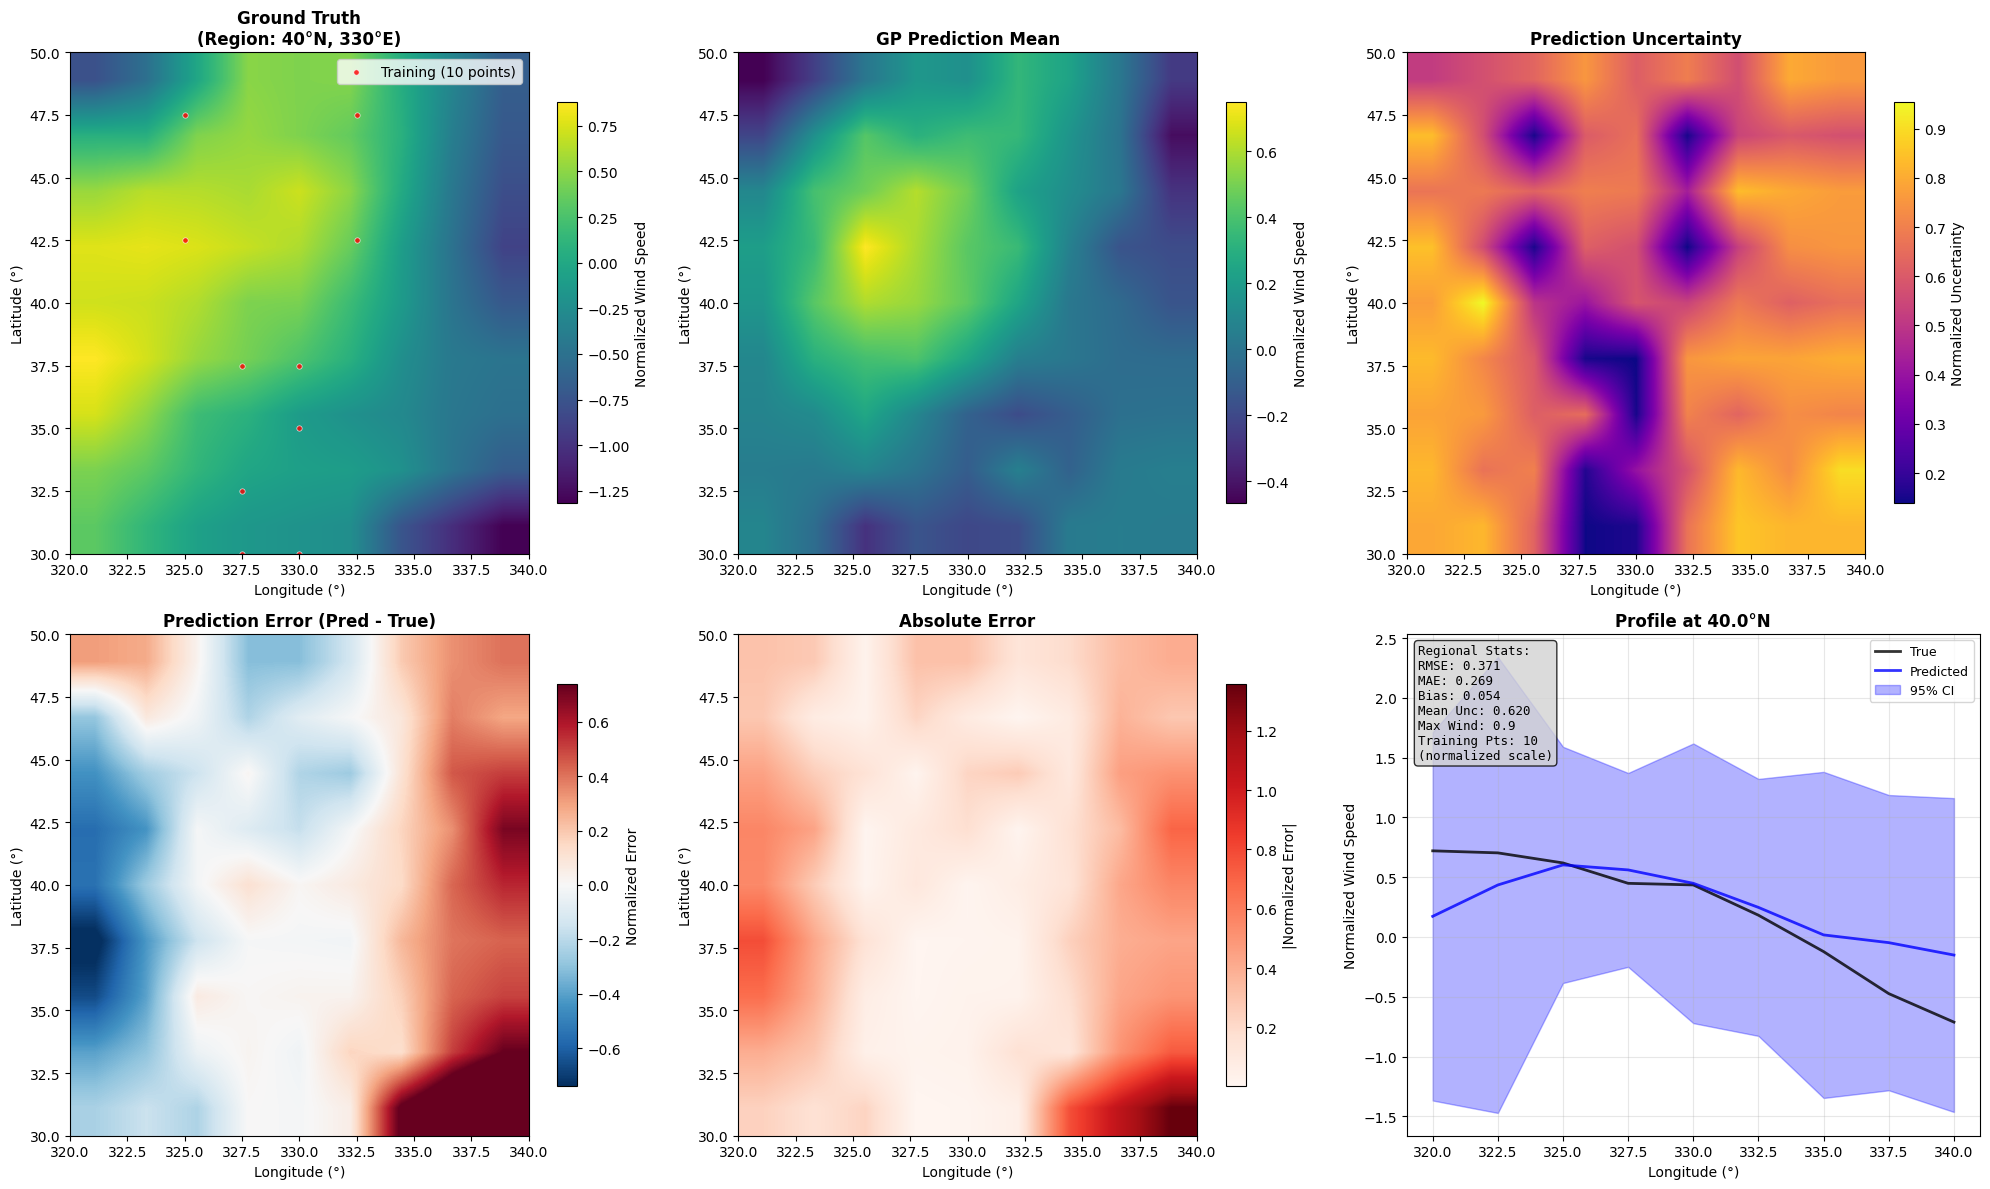


2. Pacific Ocean Region:
Regional Analysis:
Region: lat [20.0, 40.0]°, lon [170.0, 190.0]°
Regional grid: (9, 9)
Training points in region: 13
Regional RMSE: 0.956 (normalized)


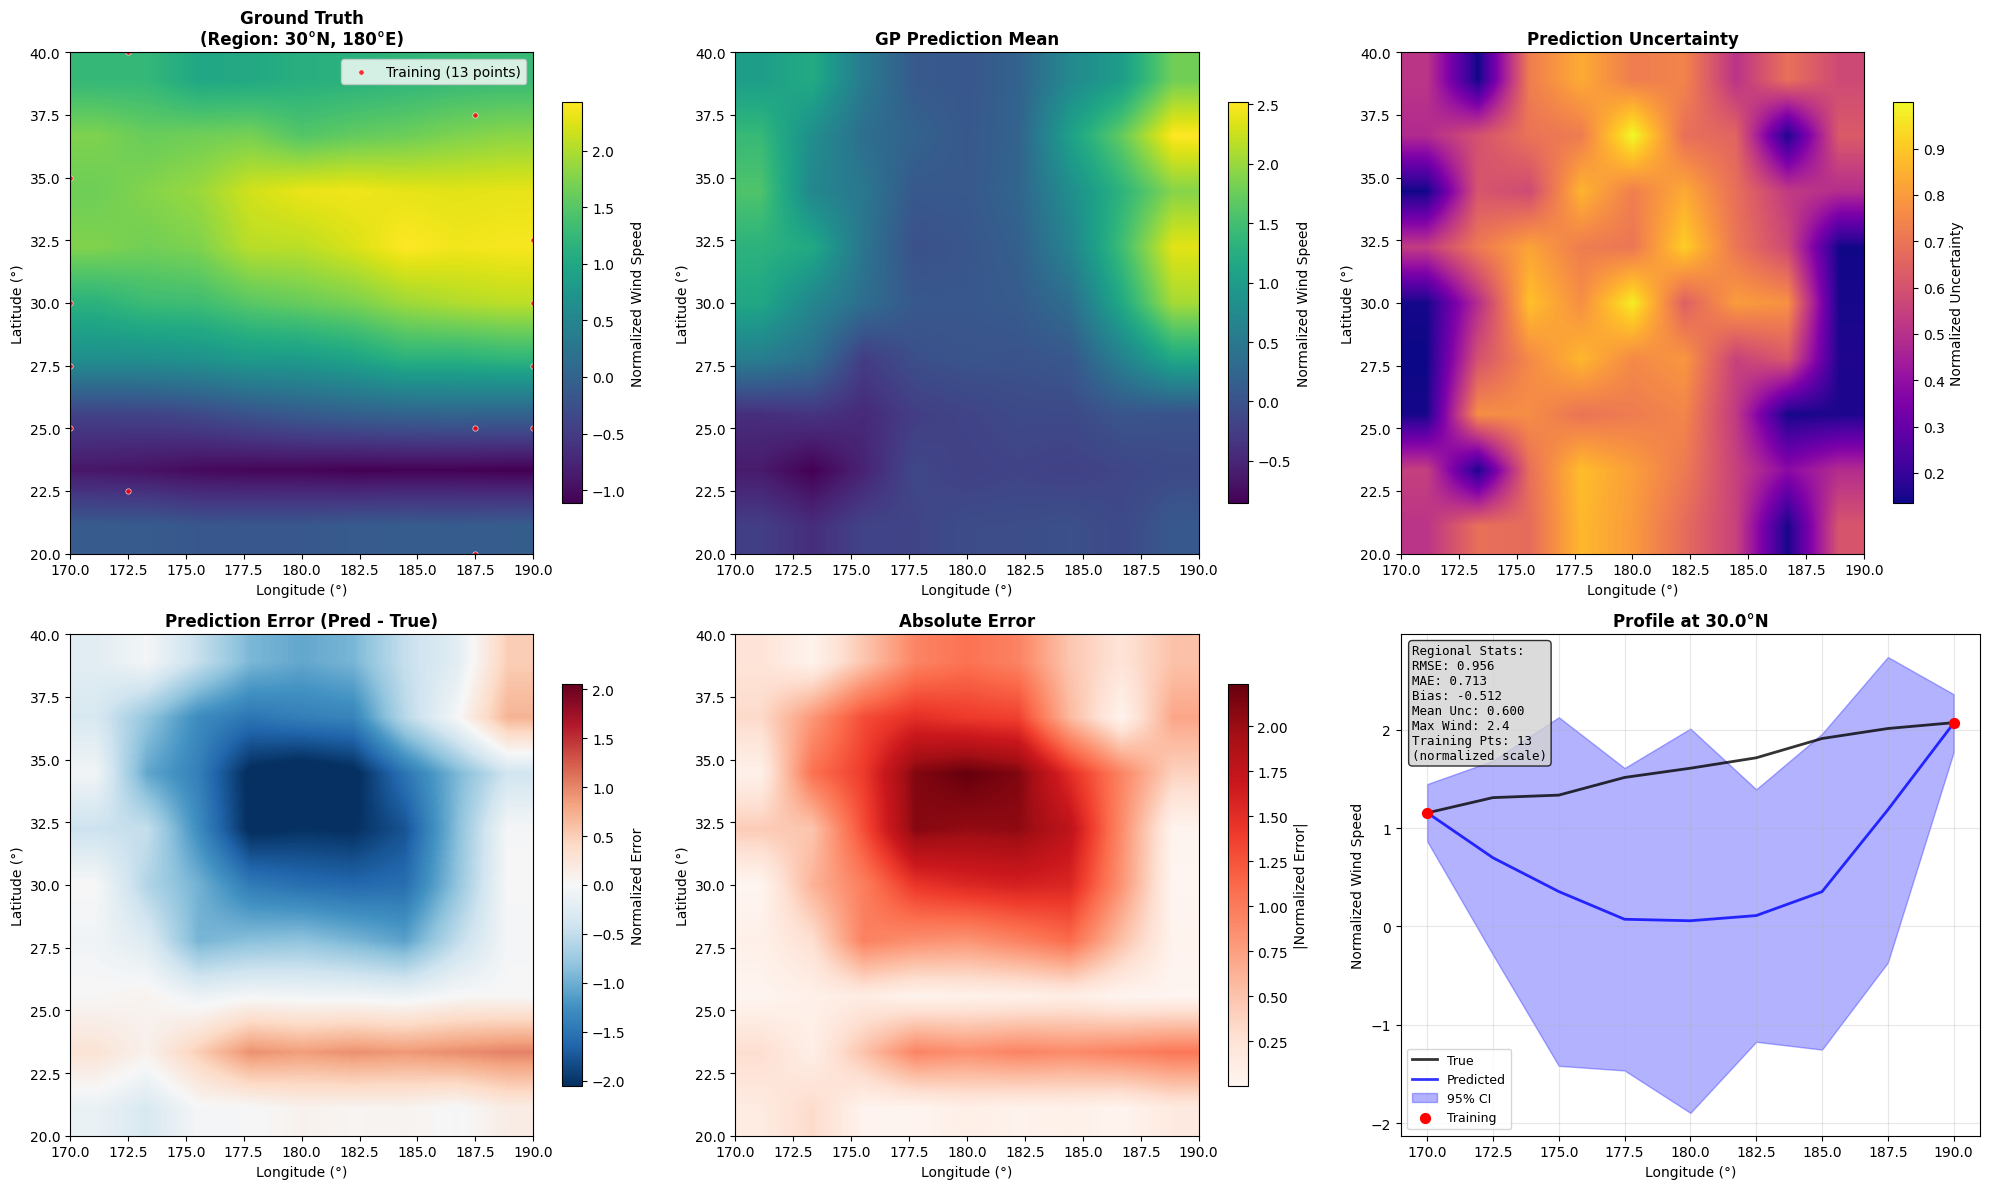


3. Asia-Europe Region:
Regional Analysis:
Region: lat [40.0, 60.0]°, lon [50.0, 70.0]°
Regional grid: (9, 9)
Training points in region: 10
Regional RMSE: 0.490 (normalized)


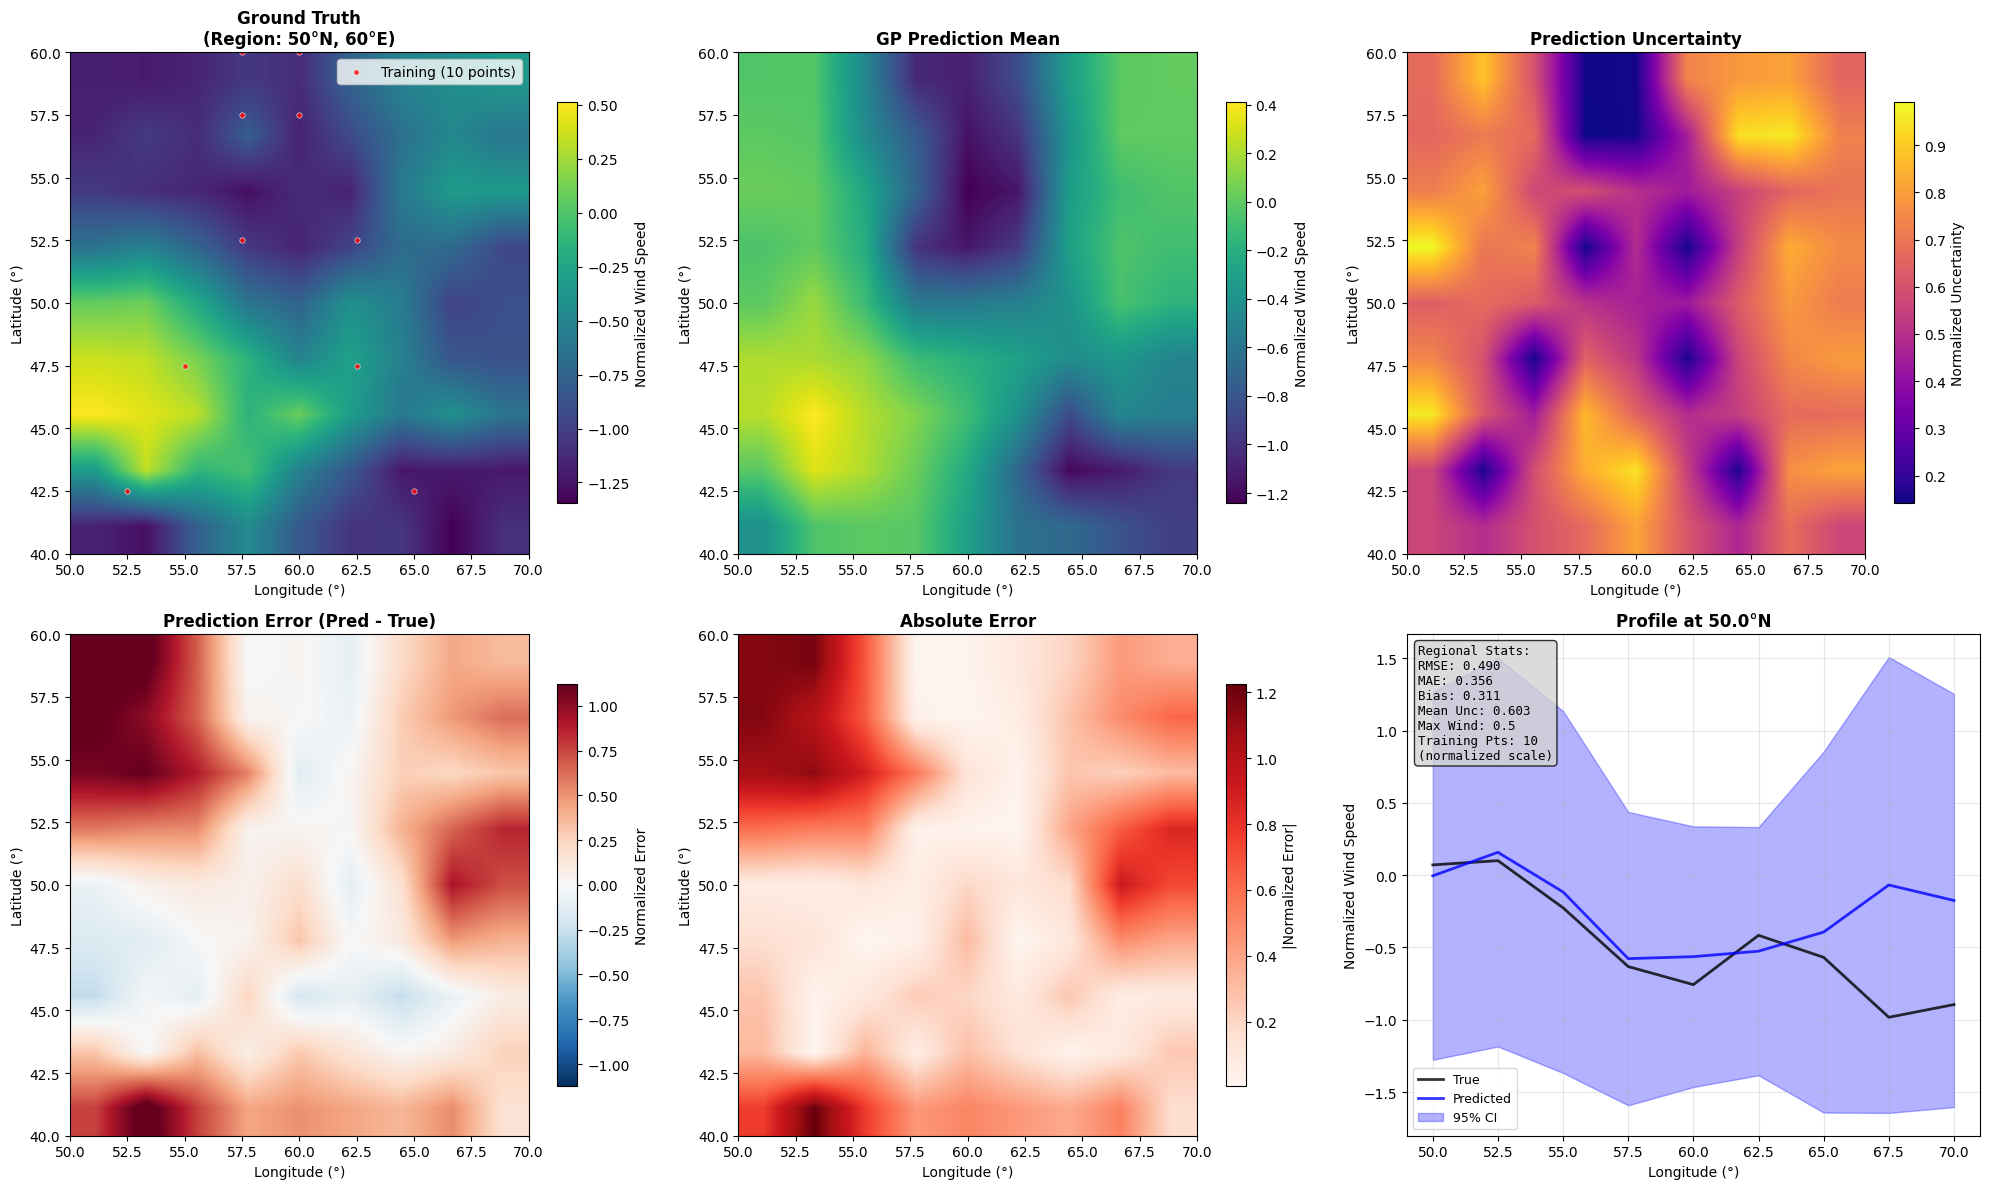

In [24]:
# =============================================================================
# REGIONAL ZOOM VISUALIZATION
# =============================================================================

def plot_regional_zoom(center_lat, center_lon, zoom_size=10, figsize=(20, 15)):
    """
    Create a detailed 6-panel visualization for a specific region
    
    Parameters:
    -----------
    center_lat : float
        Latitude of the center of the zoom region
    center_lon : float  
        Longitude of the center of the zoom region
    zoom_size : float
        Size of the zoom window in degrees (total span will be 2*zoom_size)
    figsize : tuple
        Figure size (width, height)
    """
    
    # Prepare data - use ACTUAL data dimensions
    n_lat, n_lon = len(lat_grid), len(lon_grid)  # Use processed grid dimensions  
    y_true_2d = data['y'].cpu().numpy().reshape((n_lat, n_lon))  # Normalized scale
    y_pred_2d = all_mean.cpu().numpy().reshape((n_lat, n_lon))
    uncertainty_2d = all_std.cpu().numpy().reshape((n_lat, n_lon))
    error_2d = y_pred_2d - y_true_2d
    abs_error_2d = np.abs(error_2d)
    
    # Get coordinates
    unique_lats = np.unique(data['coord_mapping'][:, 0])
    unique_lons = np.unique(data['coord_mapping'][:, 1])
    unique_lats = np.sort(unique_lats)[::-1]  # Descending: 90 to -90
    unique_lons = np.sort(unique_lons)        # Ascending: 0 to 359.75
    
    # Define zoom region bounds
    lat_min = center_lat - zoom_size
    lat_max = center_lat + zoom_size
    lon_min = center_lon - zoom_size
    lon_max = center_lon + zoom_size
    
    # Handle longitude wrapping (if needed)
    if lon_min < 0:
        lon_min += 360
    if lon_max > 360:
        lon_max -= 360
    
    # Find indices for the zoom region
    lat_indices = np.where((unique_lats >= lat_min) & (unique_lats <= lat_max))[0]
    lon_indices = np.where((unique_lons >= lon_min) & (unique_lons <= lon_max))[0]
    
    if len(lat_indices) == 0 or len(lon_indices) == 0:
        print(f"No data found in region: lat [{lat_min:.1f}, {lat_max:.1f}], lon [{lon_min:.1f}, {lon_max:.1f}]")
        return
    
    # Extract regional data
    lat_slice = slice(lat_indices.min(), lat_indices.max() + 1)
    lon_slice = slice(lon_indices.min(), lon_indices.max() + 1)
    
    region_y_true = y_true_2d[lat_slice, lon_slice]
    region_y_pred = y_pred_2d[lat_slice, lon_slice]
    region_uncertainty = uncertainty_2d[lat_slice, lon_slice]
    region_error = error_2d[lat_slice, lon_slice]
    region_abs_error = abs_error_2d[lat_slice, lon_slice]
    
    # Regional coordinate bounds
    region_lats = unique_lats[lat_slice]
    region_lons = unique_lons[lon_slice]
    region_extent = [region_lons.min(), region_lons.max(), region_lats.min(), region_lats.max()]
    
    # Get training points in this region
    train_indices = data['X_train'].flatten().int().cpu().numpy()
    train_coords = data['coord_mapping'][train_indices]
    train_mask = ((train_coords[:, 0] >= lat_min) & (train_coords[:, 0] <= lat_max) & 
                  (train_coords[:, 1] >= lon_min) & (train_coords[:, 1] <= lon_max))
    region_train_coords = train_coords[train_mask]
    
    print(f"Regional Analysis:")
    print(f"Region: lat [{lat_min:.1f}, {lat_max:.1f}]°, lon [{lon_min:.1f}, {lon_max:.1f}]°")
    print(f"Regional grid: {region_y_true.shape}")
    print(f"Training points in region: {len(region_train_coords)}")
    print(f"Regional RMSE: {np.sqrt(np.mean(region_error**2)):.3f} (normalized)")
    
    # Create the visualization
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    
    # 1. Ground Truth in Region
    ax = axes[0, 0]
    im1 = ax.imshow(region_y_true, extent=region_extent, cmap='viridis', 
                   aspect='auto', origin='upper', interpolation='bilinear')
    if len(region_train_coords) > 0:
        ax.scatter(region_train_coords[:, 1], region_train_coords[:, 0], 
                  c='red', s=15, alpha=0.8, edgecolors='white', linewidth=0.5,
                  label=f'Training ({len(region_train_coords)} points)')
        ax.legend(loc='best', fontsize=10)
    ax.set_title(f'Ground Truth\n(Region: {center_lat:.0f}°N, {center_lon:.0f}°E)', 
                fontsize=12, fontweight='bold')
    ax.set_xlabel('Longitude (°)')
    ax.set_ylabel('Latitude (°)')
    plt.colorbar(im1, ax=ax, label='Normalized Wind Speed', shrink=0.8)
    
    # 2. Predictions in Region
    ax = axes[0, 1]
    im2 = ax.imshow(region_y_pred, extent=region_extent, cmap='viridis', 
                   aspect='auto', origin='upper', interpolation='bilinear')
    ax.set_title('GP Prediction Mean', fontsize=12, fontweight='bold')
    ax.set_xlabel('Longitude (°)')
    ax.set_ylabel('Latitude (°)')
    plt.colorbar(im2, ax=ax, label='Normalized Wind Speed', shrink=0.8)
    
    # 3. Uncertainty in Region
    ax = axes[0, 2]
    im3 = ax.imshow(region_uncertainty, extent=region_extent, cmap='plasma', 
                   aspect='auto', origin='upper', interpolation='bilinear')
    ax.set_title('Prediction Uncertainty', fontsize=12, fontweight='bold')
    ax.set_xlabel('Longitude (°)')
    ax.set_ylabel('Latitude (°)')
    plt.colorbar(im3, ax=ax, label='Normalized Uncertainty', shrink=0.8)
    
    # 4. Signed Error in Region
    ax = axes[1, 0]
    max_error = np.percentile(np.abs(region_error), 95)
    im4 = ax.imshow(region_error, extent=region_extent, cmap='RdBu_r', 
                   aspect='auto', origin='upper', interpolation='bilinear',
                   vmin=-max_error, vmax=max_error)
    ax.set_title('Prediction Error (Pred - True)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Longitude (°)')
    ax.set_ylabel('Latitude (°)')
    plt.colorbar(im4, ax=ax, label='Normalized Error', shrink=0.8)
    
    # 5. Absolute Error in Region
    ax = axes[1, 1]
    im5 = ax.imshow(region_abs_error, extent=region_extent, cmap='Reds', 
                   aspect='auto', origin='upper', interpolation='bilinear')
    ax.set_title('Absolute Error', fontsize=12, fontweight='bold')
    ax.set_xlabel('Longitude (°)')
    ax.set_ylabel('Latitude (°)')
    plt.colorbar(im5, ax=ax, label='|Normalized Error|', shrink=0.8)
    
    # 6. Regional Statistics and Profiles
    ax = axes[1, 2]
    
    # Create line profiles across the region (middle row and column)
    mid_lat_idx = region_y_true.shape[0] // 2
    mid_lon_idx = region_y_true.shape[1] // 2
    
    # Longitude profile (across middle latitude)
    lon_profile_true = region_y_true[mid_lat_idx, :]
    lon_profile_pred = region_y_pred[mid_lat_idx, :]
    lon_profile_unc = region_uncertainty[mid_lat_idx, :]
    
    ax.plot(region_lons, lon_profile_true, 'k-', linewidth=2, label='True', alpha=0.8)
    ax.plot(region_lons, lon_profile_pred, 'b-', linewidth=2, label='Predicted', alpha=0.8)
    ax.fill_between(region_lons, 
                   lon_profile_pred - 2*lon_profile_unc,
                   lon_profile_pred + 2*lon_profile_unc,
                   alpha=0.3, color='blue', label='95% CI')
    
    # Mark training points on the profile
    if len(region_train_coords) > 0:
        profile_lat = region_lats[mid_lat_idx]
        nearby_train = region_train_coords[
            np.abs(region_train_coords[:, 0] - profile_lat) < 0.5
        ]
        if len(nearby_train) > 0:
            ax.scatter(nearby_train[:, 1], 
                      [np.interp(lon, region_lons, lon_profile_true) for lon in nearby_train[:, 1]],
                      c='red', s=50, zorder=5, label='Training')
    
    ax.set_xlabel('Longitude (°)')
    ax.set_ylabel('Normalized Wind Speed')
    ax.set_title(f'Profile at {region_lats[mid_lat_idx]:.1f}°N', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Add regional statistics as text
    regional_stats = f"""Regional Stats:
RMSE: {np.sqrt(np.mean(region_error**2)):.3f}
MAE: {np.mean(region_abs_error):.3f}
Bias: {np.mean(region_error):.3f}
Mean Unc: {np.mean(region_uncertainty):.3f}
Max Wind: {np.max(region_y_true):.1f}
Training Pts: {len(region_train_coords)}
(normalized scale)"""
    
    ax.text(0.02, 0.98, regional_stats, transform=ax.transAxes, fontsize=9,
           verticalalignment='top', fontfamily='monospace',
           bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return {
        'region_extent': region_extent,
        'rmse': np.sqrt(np.mean(region_error**2)),
        'mae': np.mean(region_abs_error),
        'bias': np.mean(region_error),
        'training_points': len(region_train_coords)
    }

# =============================================================================
# EXAMPLE REGIONAL ZOOMS
# =============================================================================

print("Creating regional zoom visualizations...")

# Example 1: Atlantic Ocean region (around 40°N, 30°W -> 330°E)
print("\n1. Atlantic Ocean Region:")
atlantic_stats = plot_regional_zoom(center_lat=40, center_lon=330, zoom_size=10, figsize=(20, 12))

# Example 2: Pacific Ocean region (around 30°N, 180°E)
print("\n2. Pacific Ocean Region:")
pacific_stats = plot_regional_zoom(center_lat=30, center_lon=180, zoom_size=10, figsize=(20, 12))

# Example 3: Asia-Europe region (around 50°N, 60°E)
print("\n3. Asia-Europe Region:")
asia_stats = plot_regional_zoom(center_lat=50, center_lon=60, zoom_size=10, figsize=(20, 12))